In [13]:
from Threshold import binarize
from Morphology import erode, dilate
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2

In [128]:
def keep_largest_contour(image):
    inverted = cv2.bitwise_not(image)
    contours, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        biggest_contour = max(contours, key=cv2.contourArea)
        result = np.ones_like(image) * 255
        cv2.drawContours(result, [biggest_contour], -1, (0), thickness=cv2.FILLED)
        
        return result
    
    return image

# detekcja źrenicy

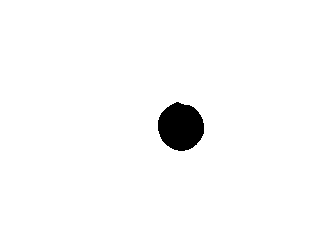

In [ ]:
image = cv2.imread('eyes/21L1.bmp', 0)
image = binarize(image, threshold=0.22)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
image = cv2.erode(image, kernel, iterations=2)
image = cv2.dilate(image, kernel, iterations=3)
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
image = cv2.medianBlur(image, 5)
image = keep_largest_contour(image)

Image.fromarray(image)

# detekcja tęczówki

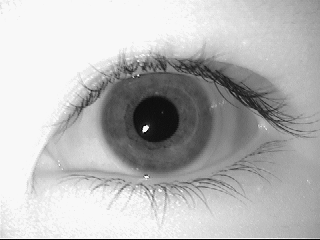

In [198]:
image = cv2.imread('eyes/1L1.bmp', 0)
Image.fromarray(image)

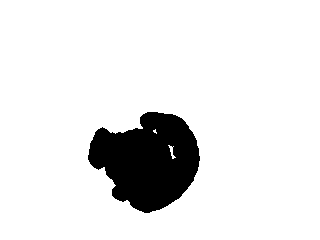

In [211]:
image = cv2.imread('eyes/9L1.bmp', 0)
image = binarize(image, threshold=0.55)
small_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
big_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
image = cv2.dilate(image, big_kernel, iterations=2)
image = cv2.erode(image, small_kernel, iterations=3)
image = keep_largest_contour(image)
image = cv2.erode(image, big_kernel, iterations=2)

#image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)
#image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
# image = cv2.medianBlur(image, 5)
# image = keep_largest_contour(image)

Image.fromarray(image)